**《深度学习之 PyTorch 实战》**

讲师作者：[土豆老师](https://iphysresearch.github.io)

# 实战Kaggle比赛：房价预测

作为深度学习基础篇章的总结，我们将对本章内容学以致用。下面，让我们动手实战一个Kaggle比赛：房价预测。本节将提供未经调优的数据的预处理、模型的设计和超参数的选择。我们希望学员通过动手操作、仔细观察实验现象、认真分析实验结果并不断调整方法，得到令自己满意的结果。

## Kaggle比赛

[Kaggle](https://www.kaggle.com/) 是一个著名的供机器学习爱好者交流的平台。图3.7展示了Kaggle网站的首页。为了便于提交结果，需要注册Kaggle账号。

我们可以在房价预测比赛的网页上了解比赛信息和参赛者成绩，也可以下载数据集并提交自己的预测结果。该比赛的网页地址是 https://www.kaggle.com/c/house-prices-advanced-regression-techniques 。

![](https://i.loli.net/2021/03/21/U6EQAVMvIhFO7XY.png)

## 获取和读取数据集

比赛数据分为训练数据集和测试数据集。

两个数据集都包括每栋房子的特征，如街道类型、建造年份、房顶类型、地下室状况等特征值。这些特征值有连续的数字、离散的标签甚至是缺失值 “na”。只有训练数据集包括了每栋房子的价格，也就是标签。我们可以访问比赛网页，点击“Data”标签，并下载这些数据集。

In [1]:
%matplotlib inline
import torch
import numpy as np
import pandas as pd
import dl4wm

print(torch.__version__, np.__version__, pd.__version__)  # 查看版本
torch.set_default_tensor_type(torch.FloatTensor)

1.3.0.post2 1.20.1 1.2.3


In [2]:
!ls Datasets/kaggle_house

data_description.txt  test.csv
sample_submission.csv train.csv


假设解压后的数据位于 `./Datasets/kaggle_house/` 目录，它包括两个 csv 文件。下面使用 pandas 读取这两个文件。

In [3]:
train_data = pd.read_csv('./Datasets/kaggle_house/train.csv')
test_data = pd.read_csv('./Datasets/kaggle_house/test.csv')

训练数据集包括 1460 个样本、80 个特征和 1 个标签。

In [4]:
train_data.shape # 输出 (1460, 81)

(1460, 81)

测试数据集包括 1459 个样本和 80 个特征。我们需要将测试数据集中每个样本的标签预测出来。

In [5]:
test_data.shape # 输出 (1459, 80)

(1459, 80)

让我们来查看前 4 个样本的前 4 个特征、后 2 个特征和标签（SalePrice）：

In [6]:
train_data.iloc[:4, [0, 1, 2, 3, -3, -2, -1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


可以看到第一个特征是 `Id`，它能帮助模型记住每个训练样本，但难以推广到测试样本，所以我们不使用它来训练。我们将所有的训练数据和测试数据的 `79` 个特征按样本纵向连结起来。

In [7]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

In [9]:
# all_features.info()

## 预处理数据

我们对连续数值的特征做**标准化**（standardization）：设该特征在整个数据集上的均值为 $\mu$，标准差为 $\sigma$。那么，我们可以将该特征的每个值先减去 $\mu$ 再除以 $\sigma$ 得到标准化后的每个特征值。对于缺失的特征值，我们将其替换成该特征的均值。

In [10]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std())
)
# 标准化后，每个数值特征的均值变为0，所以可以直接用0来替换缺失值
all_features[numeric_features] = all_features[numeric_features].fillna(0)

接下来将离散数值转成指示特征。举个例子，假设特征 `MSZoning` 里面有两个不同的离散值 `RL` 和 `RM`，那么这一步转换将去掉 `MSZoning` 特征，并新加两个特征 `MSZoning_RL` 和 `MSZoning_RM`，其值为0或1。如果一个样本原来在 `MSZoning` 里的值为 `RL`，那么有 `MSZoning_RL=1` 且 `MSZoning_RM=0`。

In [11]:
all_features.MSZoning.value_counts()  # 标识销售的一般分区分类

RL         2265
RM          460
FV          139
RH           26
C (all)      25
Name: MSZoning, dtype: int64

In [12]:
# dummy_na=True将缺失值也当作合法的特征值并为其创建指示特征
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape # (2919, 331)

(2919, 331)

可以看到这一步转换将特征数从 79 增加到了 331。

In [13]:
# 看看效果~
all_features.head(3)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan
0,0.067320,-0.184443,-0.217841,0.646073,-0.507197,1.046078,0.896679,0.523038,0.580708,-0.29303,...,0,1,0,0,0,0,0,1,0,0
1,-0.873466,0.458096,-0.072032,-0.063174,2.187904,0.154737,-0.395536,-0.569893,1.177709,-0.29303,...,0,1,0,0,0,0,0,1,0,0
2,0.067320,-0.055935,0.137173,0.646073,-0.507197,0.980053,0.848819,0.333448,0.097840,-0.29303,...,0,1,0,0,0,0,0,1,0,0


最后，通过 `values` 属性得到 NumPy 格式的数据，并转成 `Tensor` 方便后面的训练。

In [14]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float)
train_labels = torch.tensor(train_data.SalePrice.values, dtype=torch.float).view(-1, 1)
print(train_features.shape, test_features.shape, train_labels.shape)

torch.Size([1460, 331]) torch.Size([1459, 331]) torch.Size([1460, 1])


## 训练模型

我们使用一个基本的线性回归模型和平方损失函数来训练模型。

In [16]:
loss = torch.nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = torch.nn.Sequential(
        torch.nn.Linear(in_features,1),
    )
    return net

# num_hiddens1, num_hiddens2 = 64, 32
# drop_prob1, drop_prob2 = 0.1, 0.2
# def get_net():
#     net = torch.nn.Sequential(
#         torch.nn.Linear(in_features,num_hiddens1),
#         torch.nn.ReLU(),
#         torch.nn.Linear(num_hiddens1,num_hiddens2),
#         torch.nn.ReLU(),
#         torch.nn.Dropout(drop_prob2),
#         torch.nn.Linear(num_hiddens2,1),
#     )
#     return net

下面定义比赛用来评价模型的对数均方根误差。给定预测值 $\hat y_1, \ldots, \hat y_n$ 和对应的真实标签 $y_1,\ldots, y_n$，它的定义为

$$
\sqrt{\frac{1}{n}\sum_{i=1}^n\left(\log(y_i)-\log(\hat y_i)\right)^2}.
$$

对数均方根误差的实现如下：

In [15]:
def log_rmse(net, features, labels):
    with torch.no_grad():
        # 将小于1的值设成1，使得取对数时数值更稳定
        clipped_preds = torch.clamp(net(features), 1, float('inf'))
        rmse = torch.sqrt(loss(clipped_preds.log(), labels.log()))
    return rmse.item()

下面的训练函数跟前几节的不同在于使用了 Adam 优化算法。相对之前使用的小批量随机梯度下降，它对学习率相对不那么敏感。我们将在之后的“优化算法”的课程里详细介绍它。

In [17]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    dataset = torch.utils.data.TensorDataset(train_features, train_labels)
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
    # 这里使用了 Adam 优化算法
    optimizer = torch.optim.Adam(params=net.parameters(), 
                                 lr=learning_rate, 
                                 weight_decay=weight_decay)  # 权重衰减
    net = net.float()
    for epoch in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X.float()), y.float())
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

## $K$ 折交叉验证

在「模型选择、欠拟合和过拟合」中介绍了 $K$ 折交叉验证。它将被用来选择模型设计并调节超参数。下面实现了一个函数，它返回第 i 折交叉验证时所需要的训练和验证数据。

In [18]:
def get_k_fold_data(k, i, X, y):
    # 返回第i折交叉验证时所需要的训练和验证数据
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat((X_train, X_part), dim=0)
            y_train = torch.cat((y_train, y_part), dim=0)
    return X_train, y_train, X_valid, y_valid

在 $K$ 折交叉验证中我们训练 $K$ 次并返回训练和验证的平均误差。

In [19]:
def k_fold(k, X_train, y_train, num_epochs,
           learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            dl4wm.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse',
                         range(1, num_epochs + 1), valid_ls,
                         ['train', 'valid'])
        print('fold %d, train rmse: %f, valid rmse: %f' % (
            i, train_ls[-1], valid_ls[-1]))
    return train_l_sum / k, valid_l_sum / k

## 模型选择

我们使用一组未经调优的超参数并计算交叉验证误差。可以改动这些超参数来尽可能减小平均测试误差。



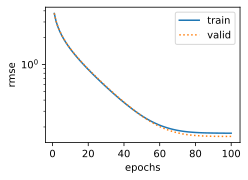

fold 0, train rmse: 0.170328, valid rmse: 0.156820
fold 1, train rmse: 0.161734, valid rmse: 0.187550
fold 2, train rmse: 0.163495, valid rmse: 0.167937
fold 3, train rmse: 0.168040, valid rmse: 0.154575
fold 4, train rmse: 0.163023, valid rmse: 0.182795
5-fold validation: avg train rmse 0.165324, avg valid rmse 0.169935


In [20]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print('%d-fold validation: avg train rmse %f, avg valid rmse %f' % (k, train_l, valid_l))

有时候你会发现一组参数的训练误差可以达到很低，但是在 $K$ 折交叉验证上的误差可能反而较高。这种现象很可能是由过拟合造成的。因此，当训练误差降低时，我们要观察 $K$ 折交叉验证上的误差是否也相应降低。

FYI:

```python
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
             legend=None, figsize=(3.5, 2.5)):
    """Plot x and log(y)."""
    set_figsize(figsize)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        plt.semilogy(x2_vals, y2_vals, linestyle=':')
        plt.legend(legend)
    plt.show()
```

## 预测并在 Kaggle 提交结果

下面定义预测函数。在预测之前，我们会使用完整的训练数据集来重新训练模型，并将预测结果存成提交所需要的格式。

In [21]:
def train_and_pred(train_features, test_feature, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    dl4wm.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse')
    print('train rmse %f' % train_ls[-1])
    
    # Apply the network to the test set
    preds = net(test_features).detach().numpy()
    
    # Reformat it for export to Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('./submission.csv', index=False)

设计好模型并调好超参数之后，下一步就是对测试数据集上的房屋样本做价格预测。如果我们得到与交叉验证时差不多的训练误差，那么这个结果很可能是理想的，可以在 Kaggle 上提交结果。

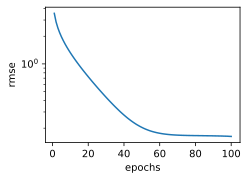

train rmse 0.162513


In [22]:
train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size)

上述代码执行完之后会生成一个submission.csv文件。这个文件是符合Kaggle比赛要求的提交格式的。这时，我们可以在Kaggle上提交我们预测得出的结果，并且查看与测试数据集上真实房价（标签）的误差。

具体来说有以下几个步骤：

- 登录Kaggle网站，访问房价预测比赛网页；
- 点击右侧“Submit Predictions”或“Late Submission”按钮；
- 点击页面下方“Upload Submission File”图标所在的虚线框选择需要提交的预测结果文件；
- 点击页面最下方的“Make Submission”按钮就可以查看结果了。

![](https://i.loli.net/2021/03/21/K7IizfqoR2clT3H.png)
